In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/word2vec-nlp-tutorial/testData.tsv.zip
/kaggle/input/word2vec-nlp-tutorial/sampleSubmission.csv
/kaggle/input/word2vec-nlp-tutorial/unlabeledTrainData.tsv.zip
/kaggle/input/word2vec-nlp-tutorial/labeledTrainData.tsv.zip


In [2]:
!pip install pycodestyle
!pip install --index-url https://test.pypi.org/simple/ nbpep8

Looking in indexes: https://test.pypi.org/simple/


In [3]:
from nbpep8.nbpep8 import pep8

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
#from bs4 import BeautifulSoup
#import re
import nltk
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import callbacks, models, layers
import matplotlib.pyplot as plt

# tokenization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [5]:
BASE = '/kaggle/input/word2vec-nlp-tutorial'
MAX_WORDS = 25_000
train = pd.read_csv(os.path.join(BASE,'labeledTrainData.tsv.zip'),
                    header=0,
                    delimiter="\t",
                    quoting=3)
train.shape

(25000, 3)

In [6]:
test = pd.read_csv(os.path.join(BASE,'testData.tsv.zip'),
                   header=0,
                   delimiter="\t",
                   quoting=3)
test.shape

(25000, 2)

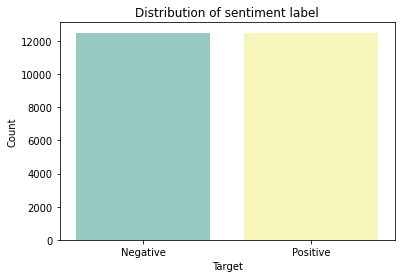

In [7]:
sns.countplot(x = 'sentiment', data = train, palette = 'Set3')
plt.xticks(ticks = [0,1], labels = ['Negative','Positive'])
plt.ylabel("Count")
plt.xlabel("Target")
plt.title("Distribution of sentiment label")
plt.show()

In [8]:
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize

def tokenizer_fct(sentence) :
    # print(sentence)
    sentence_clean = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens

def split_tokenizer_fct(sentence) :
    # print(sentence)
    sentence_clean = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ')
    word_tokens = sentence_clean.split(' ')
    return word_tokens



# lower case et alpha
def lower_start_fct(list_words) :
    lw = [w.lower() for w in list_words if (not w.startswith("@")) 
    #                                   and (not w.startswith("#"))
                                       and (not w.startswith("http"))]
    return lw

# Fonction de préparation du texte pour le Deep learning (USE et BERT)
def transform_dl_fct(desc_text) :
    word_tokens = split_tokenizer_fct(desc_text)
#    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(word_tokens)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [9]:
train['sentence_dl'] = train['review'].apply(lambda x : transform_dl_fct(x))
train[['review','sentence_dl']]

,review,sentence_dl
0,"""With all this stuff going down at the moment ...","""with all this stuff going down at the moment ..."
1,"""\""The Classic War of the Worlds\"" by Timothy ...","""\""the classic war of the worlds\"" by timothy ..."
2,"""The film starts with a manager (Nicholas Bell...","""the film starts with a manager (nicholas bell..."
3,"""It must be assumed that those who praised thi...","""it must be assumed that those who praised thi..."
4,"""Superbly trashy and wondrously unpretentious ...","""superbly trashy and wondrously unpretentious ..."
...,...,...
24995,"""It seems like more consideration has gone int...","""it seems like more consideration has gone int..."
24996,"""I don't believe they made this film. Complete...","""i don't believe they made this film. complete..."
24997,"""Guy is a loser. Can't get girls, needs to bui...","""guy is a loser. can't get girls, needs to bui..."
24998,"""This 30 minute documentary Buñuel made in the...","""this 30 minute documentary buñuel made in the..."


In [10]:
#!pip install transformers
#!pip install pytorch-transformers
# Import des librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from transformers import *
import time
# tf.compat.v1.disable_eager_execution()
path = "/content/"
print(tf.__version__)

2.6.4


In [11]:
tweets_raw = train['sentence_dl']
y = train['sentiment'].values

In [12]:
tweet_raw_train, tweet_raw_test, y_train, y_test = train_test_split(
    tweets_raw.values, y,
    test_size=0.2,
    stratify=y,
    random_state=7
)

In [13]:
train_label = y_train
test_label  = y_test
train_label

array([1, 0, 0, ..., 0, 1, 1])

In [14]:
# Preparing the sentences
def data_prep_fct(bert_tokenizer, sentences, max_length) :
    
    input_ids=[]
    attention_masks=[]
    token_type_ids=[]
    segment_ids=[]

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              truncation=True,
                                              return_attention_mask = True, 
                                              return_token_type_ids=True)
        input_ids.append(bert_inp['input_ids'])
        attention_masks.append(bert_inp['attention_mask'])
        token_type_ids.append(bert_inp['token_type_ids'])
        segment_id = [0] * max_length
        segment_ids.append(segment_id)

    input_ids = np.asarray(input_ids)
    attention_masks = np.array(attention_masks)
    token_type_ids = np.array(token_type_ids)
    segment_ids = np.array(segment_ids)
    
#     return input_ids, attention_masks
    return input_ids, attention_masks, token_type_ids, segment_ids

In [15]:
def train_test_prep_fct(bert_tokenizer) :

    print("Train tweets preparation ...")
    sentences = tweet_raw_train
    start = time.time()
    train_inp, train_mask, train_token, train_seg = data_prep_fct(
        bert_tokenizer,
        sentences,
        max_length=max_length
    )
    print("duration: ", time.time()-start)
    print()

    print("Test tweets preparation ...")
    sentences = tweet_raw_test
    start = time.time()
    test_inp, test_mask, test_token, test_seg = data_prep_fct(
        bert_tokenizer,
        sentences,
        max_length=max_length
    )
    print("duration: ", time.time()-start)
    
    return train_inp, train_mask,train_token,train_seg, test_inp, test_mask,test_token, test_seg

In [16]:
model_name = 'bert'

model_type   = 'fabriceyhc/bert-base-uncased-imdb'

max_length   = 512
bert_tokenizer = BertTokenizer.from_pretrained(model_type)
#AutoTokenizer.from_pretrained(model_type)

mt = (model_type.split('-')[0][0] + model_type.split('-')[1][0] + model_type.split('-')[2][0]).upper()
ml = 'ML' + str(max_length)
tw = 'T' + str(len(tweets_raw))
model_file_name = model_name + '_' + mt + '_' + ml + '_' + tw
model_save_path = model_file_name + '.h5'
# = path + 'models/' + model_file_name + '.h5'
print(model_save_path)

https://huggingface.co/fabriceyhc/bert-base-uncased-imdb/resolve/main/vocab.txt not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpgjvh3z3s


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

storing https://huggingface.co/fabriceyhc/bert-base-uncased-imdb/resolve/main/vocab.txt in cache at /root/.cache/huggingface/transformers/451f0b6ce35a7f7c5d785a8126ef7cc6ad60da33b383beed5bad35c32404a87d.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
creating metadata file for /root/.cache/huggingface/transformers/451f0b6ce35a7f7c5d785a8126ef7cc6ad60da33b383beed5bad35c32404a87d.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
https://huggingface.co/fabriceyhc/bert-base-uncased-imdb/resolve/main/special_tokens_map.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpwwmq8dpz


Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

storing https://huggingface.co/fabriceyhc/bert-base-uncased-imdb/resolve/main/special_tokens_map.json in cache at /root/.cache/huggingface/transformers/e60863a75b1372ac7dc58399e55b9912c2335f9e52382dea26a715521a12863c.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
creating metadata file for /root/.cache/huggingface/transformers/e60863a75b1372ac7dc58399e55b9912c2335f9e52382dea26a715521a12863c.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
https://huggingface.co/fabriceyhc/bert-base-uncased-imdb/resolve/main/tokenizer_config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpcmfyv3r5


Downloading:   0%|          | 0.00/321 [00:00<?, ?B/s]

storing https://huggingface.co/fabriceyhc/bert-base-uncased-imdb/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/302ed971b61e0e1588713b681f54356f9b2d311e4e583a926bc35a2b3722a368.59407384618422b5f582b6046df91db98a0f921d6c959dc7b1f50000ffea1032
creating metadata file for /root/.cache/huggingface/transformers/302ed971b61e0e1588713b681f54356f9b2d311e4e583a926bc35a2b3722a368.59407384618422b5f582b6046df91db98a0f921d6c959dc7b1f50000ffea1032
loading file https://huggingface.co/fabriceyhc/bert-base-uncased-imdb/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/451f0b6ce35a7f7c5d785a8126ef7cc6ad60da33b383beed5bad35c32404a87d.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/fabriceyhc/bert-base-uncased-imdb/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/fabriceyhc/bert-base-uncased-imdb/resolve/main/special_tokens_map.json from cache at /root/.ca

bert_FBU_ML512_T25000.h5


In [17]:
train_inp, train_mask, train_token, train_seg, test_inp, test_mask, test_token, test_seg = \
                                                                train_test_prep_fct(bert_tokenizer)

Train tweets preparation ...
duration:  187.95981121063232

Test tweets preparation ...
duration:  47.68765950202942


In [18]:
bert_model = TFBertForSequenceClassification.from_pretrained(model_type, num_labels=2, from_pt=True)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5, epsilon=1e-08)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')


bert_model.compile(loss=loss, optimizer=optimizer, metrics=[metric])
print(bert_model.summary())

https://huggingface.co/fabriceyhc/bert-base-uncased-imdb/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp4cddwlvq


Downloading:   0%|          | 0.00/727 [00:00<?, ?B/s]

storing https://huggingface.co/fabriceyhc/bert-base-uncased-imdb/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/bd62d309ee822caf3777ed4c3e0beea7c486a51e5a4dc929880a5d6a77837a58.994b1d248aee02666808e61dc5ffd7c6093e426f41a3c9d67bf5e301690077b2
creating metadata file for /root/.cache/huggingface/transformers/bd62d309ee822caf3777ed4c3e0beea7c486a51e5a4dc929880a5d6a77837a58.994b1d248aee02666808e61dc5ffd7c6093e426f41a3c9d67bf5e301690077b2
loading configuration file https://huggingface.co/fabriceyhc/bert-base-uncased-imdb/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/bd62d309ee822caf3777ed4c3e0beea7c486a51e5a4dc929880a5d6a77837a58.994b1d248aee02666808e61dc5ffd7c6093e426f41a3c9d67bf5e301690077b2
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_ac

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

storing https://huggingface.co/fabriceyhc/bert-base-uncased-imdb/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/d74b833be0d9a5d3c805bd51062dc1becb7c8ba5703ecad7a5c8e1a464197198.38772bd2021b1c1f49aa9cca04046acd05977dba4ff783d262c3a85ed0403899
creating metadata file for /root/.cache/huggingface/transformers/d74b833be0d9a5d3c805bd51062dc1becb7c8ba5703ecad7a5c8e1a464197198.38772bd2021b1c1f49aa9cca04046acd05977dba4ff783d262c3a85ed0403899
loading weights file https://huggingface.co/fabriceyhc/bert-base-uncased-imdb/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/d74b833be0d9a5d3c805bd51062dc1becb7c8ba5703ecad7a5c8e1a464197198.38772bd2021b1c1f49aa9cca04046acd05977dba4ff783d262c3a85ed0403899
Loading PyTorch weights from /root/.cache/huggingface/transformers/d74b833be0d9a5d3c805bd51062dc1becb7c8ba5703ecad7a5c8e1a464197198.38772bd2021b1c1f49aa9cca04046acd05977dba4ff783d262c3a85ed0403899
PyTorch checkpoint contains 109,484,290 p

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________
None


In [19]:
#checkpoint_path = "bert_FBU_ML512_T25000.{epoch:02d}-{val_loss:.2f}.h5"
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path,
                                                    save_weights_only=True,
                                                    monitor='val_loss',mode='min',
                                                    save_best_only=True, verbose=1)
callbacks = [es, mc]

history = bert_model.fit(
                         [train_inp, train_mask, train_seg], train_label,                         
                         batch_size=4, epochs=1 ,
                         validation_data=([test_inp, test_mask, test_seg],test_label),
                         callbacks=callbacks, verbose=1)

5000/5000 [==============================] - 1614s 319ms/step - loss: 0.1696 - accuracy: 0.9406 - val_loss: 0.1390 - val_accuracy: 0.9476

Epoch 00001: val_loss improved from inf to 0.13900, saving model to bert_FBU_ML512_T25000.h5


In [20]:
trained_model = bert_model
trained_model.save_weights(model_save_path)
trained_model.load_weights(model_save_path)

In [21]:
y_pred_proba = trained_model.predict([test_inp, test_mask, test_seg], batch_size=4)[0][:,1]
# print(y_pred_proba)
y_pred = np.where(y_pred_proba>0,1,0)
print("accuracy : ", metrics.accuracy_score(y_test,y_pred))
print("auc      : ", metrics.roc_auc_score(y_test,y_pred_proba))
print()

accuracy :  0.9478
auc      :  0.98869376



In [22]:
# RoBERTa
model_name = 'roberta'
model_type = 'aychang/roberta-base-imdb'
max_length   = 512
Roberta_tokenizer = AutoTokenizer.from_pretrained(model_type)
mt = (model_type.split('-')[0][0] + model_type.split('-')[1][0] + model_type.split('-')[2][0]).upper()
ml = 'ML' + str(max_length)
tw = 'T' + str(len(tweets_raw))
model_file_name = model_name + '_' + mt + '_' + ml + '_' + tw
model_save_path = model_file_name + '.h5'
print(model_save_path)

https://huggingface.co/aychang/roberta-base-imdb/resolve/main/tokenizer_config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp_wvzn3ck


Downloading:   0%|          | 0.00/255 [00:00<?, ?B/s]

storing https://huggingface.co/aychang/roberta-base-imdb/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/685831a7774aea21be020fe40fac0e140686a876b5d9c6462a8d72d6eaaa5e27.7798c29a2c53e319dac80a41f69e57b26872a2c22e75a2befcea7e1469067aa2
creating metadata file for /root/.cache/huggingface/transformers/685831a7774aea21be020fe40fac0e140686a876b5d9c6462a8d72d6eaaa5e27.7798c29a2c53e319dac80a41f69e57b26872a2c22e75a2befcea7e1469067aa2
https://huggingface.co/aychang/roberta-base-imdb/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpi2c5_sna


Downloading:   0%|          | 0.00/762 [00:00<?, ?B/s]

storing https://huggingface.co/aychang/roberta-base-imdb/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/3a53cc9e004eff1a41ae33ced2376f081573492b05b4065d3d830e64b093b8ce.8fa4a072ab2b627f0cfc13332b3226593131cd9e2c40a699eeec8b99b02afe00
creating metadata file for /root/.cache/huggingface/transformers/3a53cc9e004eff1a41ae33ced2376f081573492b05b4065d3d830e64b093b8ce.8fa4a072ab2b627f0cfc13332b3226593131cd9e2c40a699eeec8b99b02afe00
loading configuration file https://huggingface.co/aychang/roberta-base-imdb/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3a53cc9e004eff1a41ae33ced2376f081573492b05b4065d3d830e64b093b8ce.8fa4a072ab2b627f0cfc13332b3226593131cd9e2c40a699eeec8b99b02afe00
Model config RobertaConfig {
  "_name_or_path": "aychang/roberta-base-imdb",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "grad

Downloading:   0%|          | 0.00/780k [00:00<?, ?B/s]

storing https://huggingface.co/aychang/roberta-base-imdb/resolve/main/vocab.json in cache at /root/.cache/huggingface/transformers/260c5e606eaf48ab09263eab21dfe2ca80360def1ba7d6a303e9a3b618b959e8.bfdcc444ff249bca1a95ca170ec350b442f81804d7df3a95a2252217574121d7
creating metadata file for /root/.cache/huggingface/transformers/260c5e606eaf48ab09263eab21dfe2ca80360def1ba7d6a303e9a3b618b959e8.bfdcc444ff249bca1a95ca170ec350b442f81804d7df3a95a2252217574121d7
https://huggingface.co/aychang/roberta-base-imdb/resolve/main/merges.txt not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp2upy4pn7


Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

storing https://huggingface.co/aychang/roberta-base-imdb/resolve/main/merges.txt in cache at /root/.cache/huggingface/transformers/4a8b7c86d6736f3271bd05db1ba62dac1c40ce0892da819d6c539b9ac61b8495.f5b91da9e34259b8f4d88dbc97c740667a0e8430b96314460cdb04e86d4fc435
creating metadata file for /root/.cache/huggingface/transformers/4a8b7c86d6736f3271bd05db1ba62dac1c40ce0892da819d6c539b9ac61b8495.f5b91da9e34259b8f4d88dbc97c740667a0e8430b96314460cdb04e86d4fc435
https://huggingface.co/aychang/roberta-base-imdb/resolve/main/special_tokens_map.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpjtneg2bk


Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

storing https://huggingface.co/aychang/roberta-base-imdb/resolve/main/special_tokens_map.json in cache at /root/.cache/huggingface/transformers/6510d20d06993c72316ffea82138d930a6a85a7ad1fa534078a3abc1da13fa31.a11ebb04664c067c8fe5ef8f8068b0f721263414a26058692f7b2e4ba2a1b342
creating metadata file for /root/.cache/huggingface/transformers/6510d20d06993c72316ffea82138d930a6a85a7ad1fa534078a3abc1da13fa31.a11ebb04664c067c8fe5ef8f8068b0f721263414a26058692f7b2e4ba2a1b342
loading file https://huggingface.co/aychang/roberta-base-imdb/resolve/main/vocab.json from cache at /root/.cache/huggingface/transformers/260c5e606eaf48ab09263eab21dfe2ca80360def1ba7d6a303e9a3b618b959e8.bfdcc444ff249bca1a95ca170ec350b442f81804d7df3a95a2252217574121d7
loading file https://huggingface.co/aychang/roberta-base-imdb/resolve/main/merges.txt from cache at /root/.cache/huggingface/transformers/4a8b7c86d6736f3271bd05db1ba62dac1c40ce0892da819d6c539b9ac61b8495.f5b91da9e34259b8f4d88dbc97c740667a0e8430b96314460cdb04e86d4f

roberta_ABI_ML512_T25000.h5


In [23]:
train_inp, train_mask, train_token, train_seg, test_inp, test_mask, test_token, test_seg = \
                                                                train_test_prep_fct(Roberta_tokenizer)

Train tweets preparation ...
duration:  29.47382402420044

Test tweets preparation ...
duration:  7.560321092605591


In [24]:
Roberta_model = TFRobertaForSequenceClassification.from_pretrained(
    model_type,
    num_labels=2,
    from_pt=True
)
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True
)
optimizer = tf.keras.optimizers.Adam(
    learning_rate=2e-5,
    epsilon=1e-08
)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
Roberta_model.compile(loss=loss,
                      optimizer=optimizer,
                      metrics=[metric])
print(Roberta_model.summary())

loading configuration file https://huggingface.co/aychang/roberta-base-imdb/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3a53cc9e004eff1a41ae33ced2376f081573492b05b4065d3d830e64b093b8ce.8fa4a072ab2b627f0cfc13332b3226593131cd9e2c40a699eeec8b99b02afe00
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "neg",
    "1": "pos"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "neg": 0,
    "pos": 1
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  

Downloading:   0%|          | 0.00/476M [00:00<?, ?B/s]

storing https://huggingface.co/aychang/roberta-base-imdb/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/ad1e99ca2951b60f3a23becc3663612f28c96baf82e3fa53df8abee7289c7e1c.c0c772359e6efc66de8974123f13f93d42cdbdd3eb1d00011159b239d3d462fb
creating metadata file for /root/.cache/huggingface/transformers/ad1e99ca2951b60f3a23becc3663612f28c96baf82e3fa53df8abee7289c7e1c.c0c772359e6efc66de8974123f13f93d42cdbdd3eb1d00011159b239d3d462fb
loading weights file https://huggingface.co/aychang/roberta-base-imdb/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/ad1e99ca2951b60f3a23becc3663612f28c96baf82e3fa53df8abee7289c7e1c.c0c772359e6efc66de8974123f13f93d42cdbdd3eb1d00011159b239d3d462fb
Loading PyTorch weights from /root/.cache/huggingface/transformers/ad1e99ca2951b60f3a23becc3663612f28c96baf82e3fa53df8abee7289c7e1c.c0c772359e6efc66de8974123f13f93d42cdbdd3eb1d00011159b239d3d462fb
PyTorch checkpoint contains 124,647,684 parameters
Loaded

Model: "tf_roberta_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
roberta (TFRobertaMainLayer) multiple                  124055040 
_________________________________________________________________
classifier (TFRobertaClassif multiple                  592130    
Total params: 124,647,170
Trainable params: 124,647,170
Non-trainable params: 0
_________________________________________________________________
None


In [25]:
#checkpoint_path = "roberta_WBF_ML512_T25000.{epoch:02d}-{val_loss:.2f}.h5"
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                      mode='min',
                                      verbose=1,
                                      patience=5)
mc = tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path,
                                        save_weights_only=True,
                                        monitor='val_loss',mode='min',
                                        save_best_only=True, verbose=1)
callbacks = [es, mc]

history = Roberta_model.fit(
                         [train_inp, train_mask, train_seg], train_label,                         
                         batch_size=4, epochs=1,
                         validation_data=([test_inp, test_mask, test_seg],test_label),
                         callbacks=callbacks, verbose=1)

5000/5000 [==============================] - 1631s 323ms/step - loss: 0.1421 - accuracy: 0.9531 - val_loss: 0.1009 - val_accuracy: 0.9664

Epoch 00001: val_loss improved from inf to 0.10090, saving model to roberta_ABI_ML512_T25000.h5


In [26]:
trained_model = Roberta_model
trained_model.save_weights(model_save_path)
trained_model.load_weights(model_save_path)

In [27]:
y_pred_proba = trained_model.predict([test_inp, test_mask, test_seg],
                                     batch_size=4)[0][:,1]
y_pred = np.where(y_pred_proba>0,1,0)
print("Accuracy : ", metrics.accuracy_score(y_test,y_pred))
print("AUC      : ", metrics.roc_auc_score(y_test,y_pred_proba))
print()

Accuracy :  0.9672
AUC      :  0.9927836800000001



In [28]:
pred_sentences = test['review']
pred_sentences

0        "Naturally in a film who's main themes are of ...
1        "This movie is a disaster within a disaster fi...
2        "All in all, this is a movie for kids. We saw ...
3        "Afraid of the Dark left me with the impressio...
4        "A very accurate depiction of small time mob l...
                               ...                        
24995    "Sony Pictures Classics, I'm looking at you! S...
24996    "I always felt that Ms. Merkerson had never go...
24997    "I was so disappointed in this movie. I am ver...
24998    "From the opening sequence, filled with black ...
24999    "This is a great horror film for people who do...
Name: review, Length: 25000, dtype: object

In [29]:
predict_input = data_prep_fct(Roberta_tokenizer, pred_sentences, max_length)

tf_output = trained_model.predict(predict_input)[0]
tf_prediction = tf.nn.softmax(tf_output, axis=1)

labels = ['Negative','Positive'] #(0:negative, 1:positive)
label = tf.argmax(tf_prediction, axis=1)
label = label.numpy()
print(labels[label[0]])

Positive


In [30]:
tf_output_1 = tf_output[:,1]
tf_output_2 = np.where(tf_output_1>0,1,0)
tf_output_2

array([1, 0, 1, ..., 0, 1, 1])

In [31]:
output = pd.DataFrame(data={"id":test.id,"sentiment":label})
output

,id,sentiment
0,"""12311_10""",1
1,"""8348_2""",0
2,"""5828_4""",1
3,"""7186_2""",1
4,"""12128_7""",1
...,...,...
24995,"""2155_10""",1
24996,"""59_10""",1
24997,"""2531_1""",0
24998,"""7772_8""",1


In [32]:
output.to_csv('submission.csv', index=False, quoting=3)

In [33]:
pd.read_csv("submission.csv")

,id,sentiment
0,12311_10,1
1,8348_2,0
2,5828_4,1
3,7186_2,1
4,12128_7,1
...,...,...
24995,2155_10,1
24996,59_10,1
24997,2531_1,0
24998,7772_8,1
